# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

В распоряжении есть набор фотографий людей с указанием возраста.

**Задача:** построить модель, которая по фотографии определит приблизительный возраст человека. Значение метрики MAE на тестовой выборке должно быть меньше 8.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


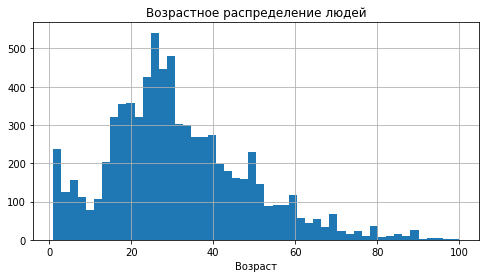

In [6]:
labels.hist(bins=50, figsize=(8, 4))
plt.title('Возрастное распределение людей')
plt.xlabel('Возраст')
plt.show()

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(train_gen_flow)

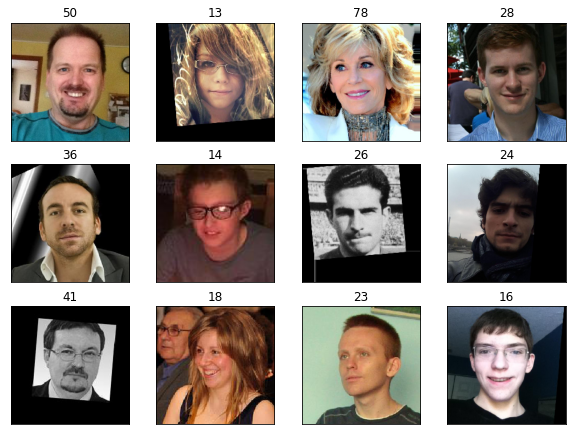

In [9]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[-i])
    plt.title(target[-i])
    plt.xticks([])
    plt.yticks([])

**Вывод**  
В исходном датасете 7591 изображений с фотографиями людей и их возрастом. Разрешение изображений привели к одному виду 224x224. Распределение по возрасту похоже на нормальное с пиком в 25-30 лет. Некоторые фотографии повернуты и наклонены.

## Обучение модели

Код обучения модели.

```python
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
        )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):   
  
    model.fit(  
        train_data,  
        validation_data=test_data,
        batch_size=batch_size,        
        epochs=epochs,  
        steps_per_epoch=len(train_data),  
        validation_steps=len(test_data),  
        verbose=2
    )  

    return model
```

Вывод результата на экран.

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 69s - loss: 201.3923 - mae: 10.3660 - val_loss: 417.7355 - val_mae: 15.3420
Epoch 2/10
356/356 - 56s - loss: 85.5457 - mae: 6.9722 - val_loss: 118.6474 - val_mae: 8.2556
Epoch 3/10
356/356 - 56s - loss: 58.7870 - mae: 5.8253 - val_loss: 87.8205 - val_mae: 7.0651
Epoch 4/10
356/356 - 56s - loss: 43.3702 - mae: 5.0505 - val_loss: 84.3591 - val_mae: 6.8910
Epoch 5/10
356/356 - 49s - loss: 34.7985 - mae: 4.4685 - val_loss: 86.8021 - val_mae: 7.2952
Epoch 6/10
356/356 - 48s - loss: 24.6190 - mae: 3.7755 - val_loss: 76.1813 - val_mae: 6.4919
Epoch 7/10
356/356 - 48s - loss: 19.8347 - mae: 3.4207 - val_loss: 71.5227 - val_mae: 6.3634
Epoch 8/10
356/356 - 47s - loss: 16.6645 - mae: 3.1235 - val_loss: 80.5959 - val_mae: 6.7900
Epoch 9/10
356/356 - 48s - loss: 13.9294 - mae: 2.8500 - val_loss: 67.8343 - val_mae: 6.2644
Epoch 10/10
356/356 - 48s - loss: 12.6026 - mae: 2.7118 - val_loss: 72.5406 - val_mae: 6.5217
119/119 - 12s - loss: 72.5406 - mae: 6.5217
```

**Вывод**  
Созданы четыре функции: загрузка тренировочных данных - load_train(path), загрузка тестовых данных - load_test(path), создания модели - create_model(input_shape), обучения моедли - train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps). В качестве модели была выбрана ResNet50. Выполнена аугментация тренировочных данных, использована horizontal_flip (зеркальное отображение). При компиляции модели использован алгоритм Adam c lr=0.0001, благодаря чему удалось достичь необходимой точности модели - MAE = 6.5217. В качестве loss-функции использовали MSE.

## Анализ обученной модели

**Итоговый вывод**  
В исходном датасете 7591 изображений с фотографиями людей и их возрастом. Разрешение изображений привели к одному виду 224x224. Распределение по возрасту похоже на нормальное с пиком в 25-30 лет. Некоторые фотографии повернуты и наклонены.   
Созданы четыре функции: загрузка тренировочных данных - load_train(path), загрузка тестовых данных - load_test(path), создания модели - create_model(input_shape), обучения моедли - train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps). В качестве модели была выбрана ResNet50. Выполнена аугментация тренировочных данных, использована horizontal_flip (зеркальное отображение). При компиляции модели использован алгоритм Adam c lr=0.0001, благодаря чему удалось достичь необходимой точности модели - MAE = 6.5217. В качестве loss-функции использовали MSE.   
Как видим из вывода консоли, уже на 6 эпохе обучения результат MAE аналогичен результату 10 эпохи. Полученое значение MAE говорит о том, что модель в среднем ошибается на 6.5 лет при определении возраста человека по фотографии, что достаточно хорошо, чтобы определить возрастную группу человека. Для контроля продажи алкоголя этой точности недостаточно.